In [1]:
import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
# Define the date range
start_date = '2010-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

# Download stock data for Tesla (TSLA)
tesla_stock = yf.download('TSLA', start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [3]:
tesla_stock.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2010-06-29,1.592667,1.592667,1.666667,1.169333,1.266667,281494500
2010-06-30,1.588667,1.588667,2.028000,1.553333,1.719333,257806500
2010-07-01,1.464000,1.464000,1.728000,1.351333,1.666667,123282000
2010-07-02,1.280000,1.280000,1.540000,1.247333,1.533333,77097000
2010-07-06,1.074000,1.074000,1.333333,1.055333,1.333333,103003500


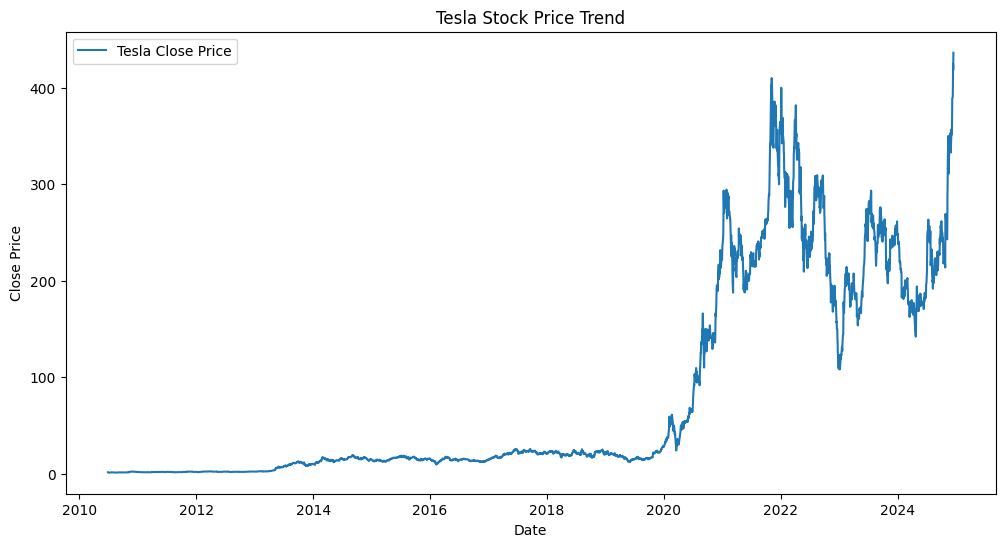

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(tesla_stock['Close'], label='Tesla Close Price')
plt.title('Tesla Stock Price Trend')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [5]:
# Set Date as index if not already
if 'Date' not in tesla_stock.columns:
    tesla_stock['Date'] = tesla_stock.index
tesla_stock.set_index('Date', inplace=True)

tesla_prices = tesla_stock['Close'].values.reshape(-1, 1)

# Scale data
scaler = MinMaxScaler()
tesla_prices_scaled = scaler.fit_transform(tesla_prices)
joblib.dump(scaler, "tesla_scaler_15.joblib")  # Save the fitted scaler


# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(tesla_prices_scaled) * 0.8)
train_data = tesla_prices_scaled[:train_size]
test_data = tesla_prices_scaled[train_size:]

# Create sequences for LSTM model
def create_sequences(data, seq_length):
    sequences = []
    labels = []

    for i in range(len(data) - seq_length - 15 + 1):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length:i + seq_length + 15])

    return np.array(sequences), np.array(labels)

seq_length = 120
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [6]:
# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(15))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

c:\Users\omar\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 120, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,265 (126.04 KB)

 Trainable params: 32,265 (126.04 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Early stopping to prevent overfitting and stop training when validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=10,           # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the best weights after stopping
)

# Model checkpoint to save the best model during training
model_checkpoint = ModelCheckpoint(
    filepath='best_lstm_model_15.keras',  # Filepath to save the model
    monitor='val_loss',            # Monitor validation loss
    save_best_only=True,           # Save only when the model is the best
    verbose=1                      # Print saving info
)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',            # Monitor validation loss
    factor=0.5,                    # Reduce learning rate by a factor of 0.5
    patience=5,                    # Number of epochs with no improvement before reducing
    min_lr=1e-6,                   # Minimum learning rate
    verbose=1                      # Print learning rate reduction info
)

# Combine callbacks into a list
callbacks = [early_stopping, model_checkpoint, reduce_lr]


In [8]:
history = model.fit(
    X_train, 
    y_train, 
    batch_size=8, 
    epochs=50, 
    validation_data=(X_test, y_test), 
    callbacks=callbacks  # Include callbacks in training
)


Epoch 1/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0068
Epoch 1: val_loss improved from inf to 0.00606, saving model to best_lstm_model_15.keras
348/348 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - loss: 0.0067 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 2/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0012
Epoch 2: val_loss improved from 0.00606 to 0.00518, saving model to best_lstm_model_15.keras
348/348 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - loss: 0.0012 - val_loss: 0.0052 - learning_rate: 0.0010
Epoch 3/50
347/348 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 8.9924e-04
Epoch 3: val_loss did not improve from 0.00518
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - loss: 8.9916e-04 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 4/50
347/348 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 8.3857e-04
Epoch 4: val_loss did not improve from 0.00518
348/348 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - loss: 8.3818e-04 - val_loss: 0.0065 - learning_rate: 0.0010
Epoch 5/50
348/348 ━━━━━━━━━━━━━

In [9]:
# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [10]:
# Evaluate model performance
y_test_reshaped = y_test.squeeze()

def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"RMSE: {rmse}, MAE: {mae}, R2: {r2}")

evaluate_model(y_test_reshaped, predictions)

RMSE: 226.51424181100472, MAE: 222.4936922015417, R2: -4271422.728748793


[*********************100%***********************]  1 of 1 completed

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


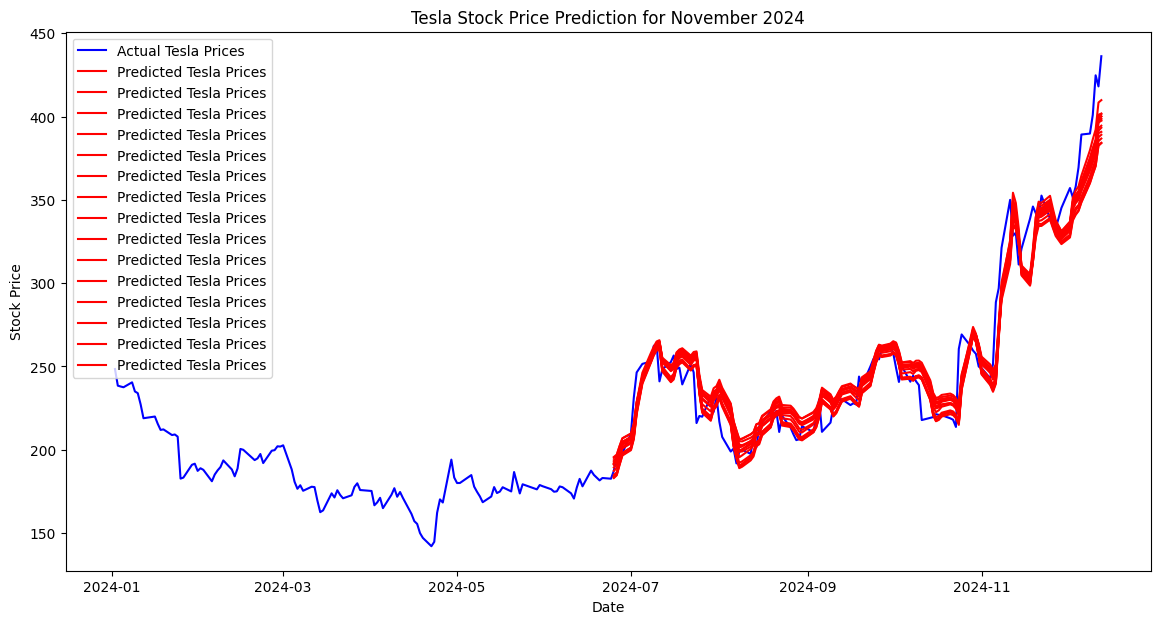

In [11]:
# Fetch data from Yahoo Finance
end_date = datetime.now().strftime('%Y-%m-%d')

tesla_stock = yf.download("TSLA", start="2024-01-01", end=end_date)
tesla_stock['Date'] = tesla_stock.index
tesla_prices = tesla_stock['Close'].values.reshape(-1, 1)

# Scale the data using the same scaler
# scaler = MinMaxScaler()
tesla_prices_scaled = scaler.transform(tesla_prices)

# Create sequences for prediction
seq_length = 120
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)

X_future = create_sequences(tesla_prices_scaled, seq_length)

# Predict November 2024 stock prices
predictions = model.predict(X_future)
predictions_rescaled = scaler.inverse_transform(predictions)

# Plot real vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(tesla_stock['Date'], tesla_stock['Close'], label="Actual Tesla Prices", color='blue')
plt.plot(tesla_stock['Date'][seq_length:], predictions_rescaled, label="Predicted Tesla Prices", color='red')
plt.title("Tesla Stock Price Prediction for November 2024")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


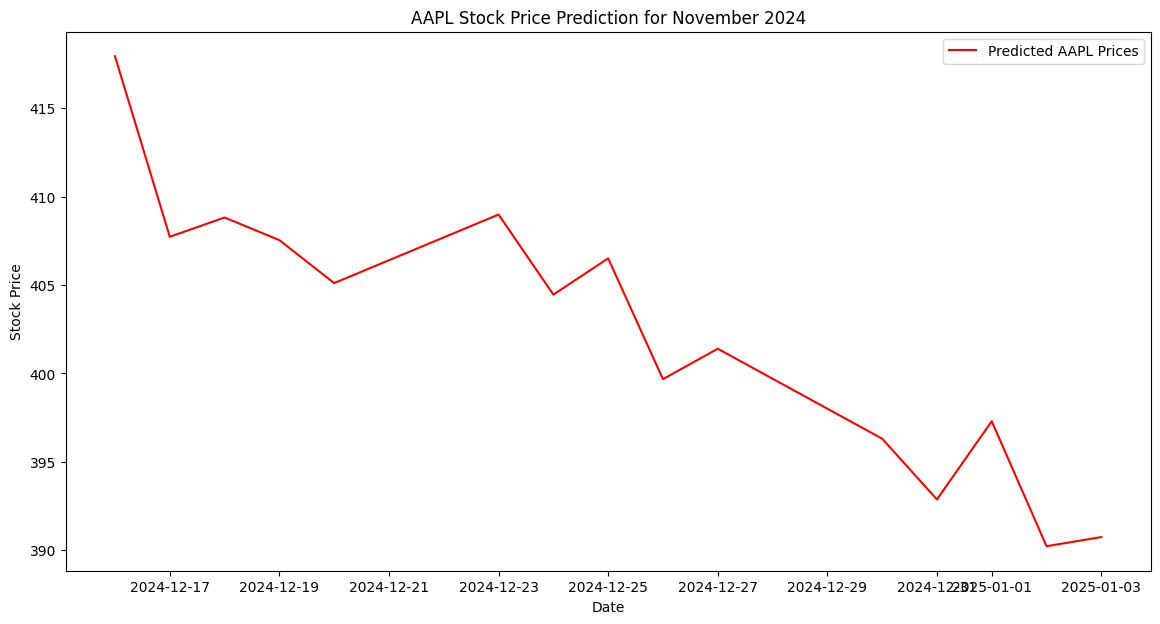

In [12]:
seq_length=120
# Prepare future prediction sequence
X_future = tesla_prices_scaled[-seq_length:].reshape(1, seq_length, 1)

# Predict November 2024 stock prices
predictions = model.predict(X_future)
predictions_rescaled = scaler.inverse_transform(predictions)

# Generate future dates for plotting
# future_dates = pd.date_range(start=datetime.now().strftime('%Y-%m-%d'), periods=11, freq='B')[1:]  # Exclude last known date

# Generate future dates from 14-12-2024 to 24-12-2024
future_dates = pd.date_range(start="2024-12-14", end="2025-1-3", freq='B')



# Plot the real vs. predicted prices
plt.figure(figsize=(14, 7))
plt.plot(future_dates, predictions_rescaled.flatten(), label="Predicted AAPL Prices", color='red')  # Predicted
plt.title("AAPL Stock Price Prediction for November 2024")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()